In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

#change path
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'python_lesson/CloneCoding/펭귄 몸무게 예측 경진대회'
os.chdir(base_dir)

#mount google driver
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"

!pwd

/content/drive/My Drive/python_lesson/CloneCoding/펭귄 몸무게 예측 경진대회


# 펭귄 몸무게 예측 경진대회 - 앙상블 기법

---

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action='ignore')

# csv 형식으로 된 데이터 파일을 읽어옵니다.
data = pd.read_csv('data/penguins.csv')

# 데이터의 최상단 5 줄을 표시합니다.
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,Male
1,Adelie,Torgersen,39.5,17.4,186,3800,Female
2,Adelie,Torgersen,40.3,18.0,195,3250,Female
3,Adelie,Torgersen,36.7,19.3,193,3450,Female
4,Adelie,Torgersen,39.3,20.6,190,3650,Male


### 데이터 분할

In [4]:
# train/test로 분할

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, shuffle=True)

print(train.shape)
print(test.shape)

(266, 7)
(67, 7)


### 결측치 조회

In [5]:
print(f"train 결측치 조회\n{train.isna().sum()}")
print('\n')
print(f"test 결측치 조회\n{test.isna().sum()}")

train 결측치 조회
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


test 결측치 조회
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


### Sex에 대하여 보간법 진행

보간법은 쉽게 말해 'Sex'를 예측하는 모델을 만들고 그 예측 값을 넣어주는 것을 의미합니다.<br>
현재 데이터엔 결측치가 없지만, 만약 평가 기준 데이터와 행 개수가 달라져서 평가를 진행할 수 없을 경우, 결측치에 보간법을 적용하여 나온 예측값을 대입한다.

In [6]:
X_train_Sex = train.select_dtypes(include=['int', 'float'])
X_train_Sex = X_train_Sex.drop('body_mass_g', axis=1)
Y_train_Sex = train['sex']

from sklearn.model_selection import train_test_split

sex_x_train, sex_x_test, sex_y_train, sex_y_test = train_test_split(X_train_Sex, Y_train_Sex)

from sklearn.ensemble import RandomForestClassifier
model_sex = RandomForestClassifier().fit(sex_x_train, sex_y_train)
model_sex.score(sex_x_test, sex_y_test)

0.8507462686567164

RandomForestClassifier 모델을 통해 성별을 예측하는 모델을 만들었습니다. <br>

그 후, train/test 셋 결측치를 대체해 줍니다.

In [7]:
# train.loc[train['sex'].isna(), 'sex'] = model_sex.predict(train[train['sex'].isna()].select_dtypes(include=['int', 'float']).drop('body_mass_g', axis=1))
# test.loc[test['sex'].isna(), 'sex'] = model_sex.predict(test[test['sex'].isna()].select_dtypes(include=['int', 'float']).drop('body_mass_g', axis=1))

#### 성별 숫자화 (MALE: 0, FEMALE: 1)

In [8]:
train.loc[train['sex'] == 'MALE', 'sex'] = 0
train.loc[train['sex'] == 'FEMALE', 'sex'] = 1

pd.get_dummies 함수는 정형 데이터에 대해 자동으로 One-Hot 인코딩을 진행해주는 똑똑한 함수입니다.

In [9]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [12]:
X = train.drop('body_mass_g', axis = 1)
Y = train['body_mass_g']
Y

148    4450
19     3800
95     4725
268    3525
128    3425
       ... 
141    3475
277    3700
270    3950
299    3600
165    5350
Name: body_mass_g, Length: 266, dtype: int64

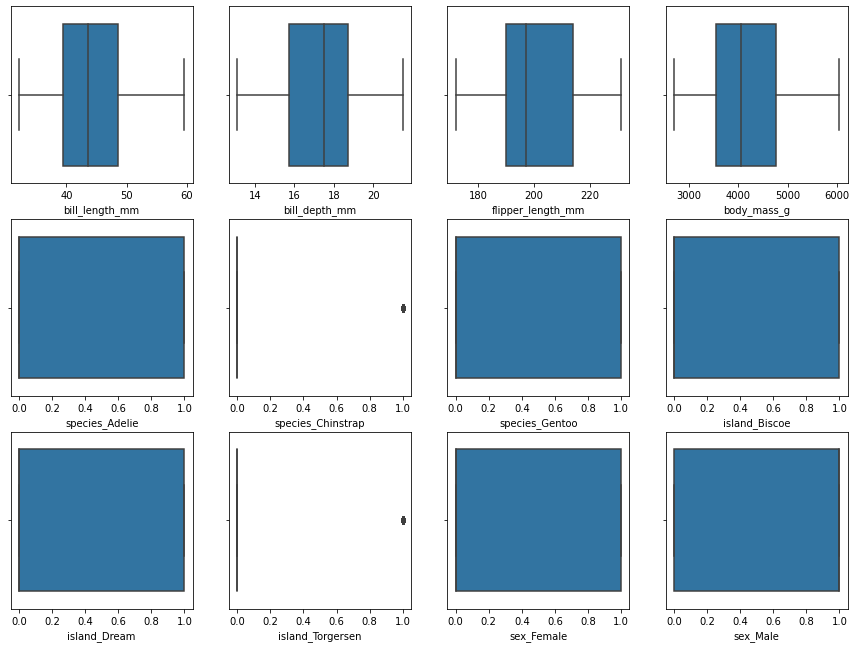

In [15]:
plt.figure(figsize=(15, 15))

for idx, col in enumerate(list(train)):
    plt.subplot(4, 4, idx+1)
    sns.boxplot(train[col])

In [16]:
X

,bill_length_mm,bill_depth_mm,flipper_length_mm,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
148,48.7,14.1,210,0,0,1,1,0,0,1,0
19,38.8,17.2,180,1,0,0,1,0,0,0,1
95,41.0,20.0,203,1,0,0,1,0,0,0,1
268,45.4,18.7,188,0,1,0,0,1,0,1,0
128,38.1,17.6,187,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
141,36.6,18.4,184,1,0,0,0,1,0,1,0
277,47.0,17.3,185,0,1,0,0,1,0,1,0
270,45.2,17.8,198,0,1,0,0,1,0,1,0
299,49.7,18.6,195,0,1,0,0,1,0,0,1


In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

### 앙상블

In [36]:
# 대회 규칙의 평가 산식 함수를 그대로 사용합니다.
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [34]:
score_List=[]

model = KNeighborsRegressor(n_neighbors=5).fit(x_train, y_train)
score_List.append(f'KNeighborsRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = LinearRegression().fit(x_train, y_train)
score_List.append(f'LinearRegression: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = Ridge().fit(x_train, y_train)
score_List.append(f'Ridge: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = Lasso().fit(x_train, y_train)
score_List.append(f'Lasso: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = DecisionTreeRegressor().fit(x_train, y_train)
score_List.append(f'DecisionTreeRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = RandomForestRegressor().fit(x_train, y_train)
score_List.append(f'RandomForestRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = GradientBoostingRegressor().fit(x_train, y_train)
score_List.append(f'GradientBoostingRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = XGBRegressor().fit(x_train, y_train)
score_List.append(f'XGBRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = LGBMRegressor().fit(x_train, y_train)
score_List.append(f'LGBMRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

[15:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [20]:
[print(i) for i in score_List]

KNeighborsRegressor: train_score: 0.8803363962279462, val_score: 0.7933886373166549
LinearRegression: train_score: 0.881085436442864, val_score: 0.9026465459532702
Ridge: train_score: 0.8804550085527272, val_score: 0.8991719927166361
Lasso: train_score: 0.8809822355800737, val_score: 0.9008815770538694
DecisionTreeRegressor: train_score: 1.0, val_score: 0.7855436067988845
RandomForestRegressor: train_score: 0.9805153837719698, val_score: 0.859745057585513
GradientBoostingRegressor: train_score: 0.9620818179921043, val_score: 0.8652209147331723
XGBRegressor: train_score: 0.9471018837041969, val_score: 0.8574249030328505
LGBMRegressor: train_score: 0.9416604203040451, val_score: 0.8590952584806555


[None, None, None, None, None, None, None, None, None]

val_score를 통해 앙상블 모델을 선별한다.

따라서 LinearRegreesion과 Ridge와 Lasso와 RandomForestRegressor, XBGRegressor, LGMBRegressor 모델을 선택합니다.

In [35]:
train_pred_LR = model_LR.predict(x_test)
train_pred_RID = model_RID.predict(x_test)
train_pred_LA = model_LA.predict(x_test)
train_pred_RF = model_RF.predict(x_test)
train_pred_LGBM = model_LGBM.predict(x_test)
train_pred_XGB = model_XGB.predict(x_test)

In [40]:
LR_RMSE = RMSE(y_test, train_pred_LR)
RID_RMSE = RMSE(y_test, train_pred_RID)
LA_RMSE = RMSE(y_test, train_pred_LA)
RF_RMSE = RMSE(y_test, train_pred_RF)
LGBM_RMSE = RMSE(y_test, train_pred_LGBM)
XGB_RMSE = RMSE(y_test, train_pred_XGB)

In [41]:
print(f"LinearRegression의 RMSE는 {LR_RMSE}")
print(f"Ridge의 RMSE는 {RID_RMSE}")
print(f"Lasso의 RMSE는 {LA_RMSE}")
print(f"RandomForestRegressor의 RMSE는 {RF_RMSE}")
print(f"LGBMRegressor의 RMSE는 {LGBM_RMSE}")
print(f"XGBRegressor의 RMSE는 {XGB_RMSE}")

LinearRegression의 RMSE는 262.0920954293933
Ridge의 RMSE는 266.0611240179336
Lasso의 RMSE는 264.1135616532076
RandomForestRegressor의 RMSE는 123.2848065193701
LGBMRegressor의 RMSE는 207.04874516481806
XGBRegressor의 RMSE는 212.25846161142474


In [42]:
# 앙상블 모형 최종 RMSE
print(f"앙상블 모형 최종 RMSE는 {(LR_RMSE+RID_RMSE+LA_RMSE+RF_RMSE+LGBM_RMSE+XGB_RMSE)/6}")

앙상블 모형 최종 RMSE는 222.47646573269125


test 예측하기

In [22]:
model_LR = LinearRegression().fit(X, Y)
model_RID = Ridge().fit(X,Y)
model_LA = Lasso().fit(X,Y)
model_RF = RandomForestRegressor().fit(X,Y)
model_LGBM = LGBMRegressor().fit(X,Y)
model_XGB = XGBRegressor().fit(X,Y)


[15:23:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
test = test.drop(['body_mass_g'], axis=1)
test

,bill_length_mm,bill_depth_mm,flipper_length_mm,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
273,46.0,18.9,195,0,1,0,0,1,0,1,0
3,36.7,19.3,193,1,0,0,0,0,1,1,0
329,43.5,18.1,202,0,1,0,0,1,0,1,0
292,49.5,19.0,200,0,1,0,0,1,0,0,1
150,47.6,14.5,215,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
54,35.7,16.9,185,1,0,0,1,0,0,1,0
101,38.2,20.0,190,1,0,0,1,0,0,0,1
291,50.5,18.4,200,0,1,0,0,1,0,1,0
205,45.3,13.8,208,0,0,1,1,0,0,1,0


적당한 비율로 곱한 후 모두 더함으로써 모델 앙상블을 진행하였습니다.

In [30]:
# 앙상블 진행

pred_LR = model_LR.predict(test)
pred_RID = model_RID.predict(test)
pred_LA = model_LA.predict(test)
pred_RF = model_RF.predict(test)
pred_LGBM = model_LGBM.predict(test)
pred_XGB = model_XGB.predict(test)

pred = pred_LR*0.167 + pred_RID*0.167 + pred_LA * 0.167 + pred_RF * 0.166 + pred_LGBM * 0.166 + pred_XGB*0.167
pred

array([3550.77544089, 3573.69210829, 3589.91494139, 4009.45216317,
       5328.53947421, 4726.108756  , 4350.76213521, 3806.54848561,
       4146.40078016, 3209.11399182, 3271.86979356, 5403.44353261,
       5324.08471985, 4642.17161669, 3326.23441351, 3775.7554837 ,
       3412.60140346, 3407.97486173, 4129.96260243, 3843.7277138 ,
       4807.52005817, 3289.06774863, 3493.34302323, 4484.95966896,
       3493.61977882, 3890.47014136, 3976.65873375, 5410.57295293,
       5169.12659916, 4155.9970733 , 5651.05717877, 3546.25996625,
       4069.76924223, 4478.66355103, 4041.95019466, 4574.13533341,
       4841.88294771, 3895.4664555 , 4817.06224137, 3499.22844426,
       3921.51473442, 3405.99598848, 5552.25650167, 3929.99413895,
       5379.36896165, 3463.44085845, 3402.42407413, 3384.69552562,
       3255.11102462, 3194.6419515 , 5270.86656048, 5269.04848841,
       4488.84039729, 4830.84785429, 3886.22116908, 5660.28225169,
       5340.0719137 , 3333.38690341, 4761.12410097, 4662.79598

다른 방식

In [32]:
pred = (pred_LR + pred_RID + pred_LA + pred_RF + pred_LGBM + pred_XGB)/6
pred

array([3550.84267919, 3573.7328282 , 3590.07151266, 4009.32400939,
       5328.83591394, 4726.07606775, 4350.90968813, 3806.41738659,
       4146.39315476, 3209.17905405, 3271.7124831 , 5403.54123014,
       5324.00296902, 4642.05938688, 3326.30849203, 3775.51487   ,
       3412.73132314, 3407.84316221, 4129.88031069, 3843.80816746,
       4807.55086008, 3289.06067317, 3493.2827371 , 4484.84615053,
       3493.5193384 , 3890.68819497, 3976.52471173, 5410.45727042,
       5169.32782406, 4156.12860985, 5651.02487025, 3546.31192291,
       4069.84989796, 4478.48676499, 4041.81190295, 4573.99106761,
       4842.01538632, 3895.63162163, 4817.08471094, 3499.30092777,
       3921.65213709, 3405.80359045, 5552.44834836, 3929.5887133 ,
       5379.34845792, 3463.32723909, 3402.28180611, 3384.95775114,
       3254.96245165, 3194.45905728, 5270.73438773, 5268.79983898,
       4488.65826825, 4830.9069047 , 3886.3227889 , 5660.25633292,
       5339.94301994, 3333.33516561, 4761.1010034 , 4662.73391

## Reference
1. https://sjkoding.tistory.com/7
2. https://www.kaggle.com/resulcaliskan/penguins